In [14]:
"""
Created on Aug 8 14:24:37 2020

@author: Nicolas Matentzoglu
"""

import os, sys
import yaml
import urllib.request
from shutil import copyfile
import pandas as pd
from subprocess import check_call
from lib import uPhenoConfig, get_defined_phenotypes

### Configuration
yaml.warnings({'YAMLLoadWarning': False})
#upheno_config_file = sys.argv[1]
upheno_config_file = os.path.join("/Users/matentzn/ws/upheno-dev/src/curation/upheno-config.yaml")
ws = "/Users/matentzn/tmp_data/var/lib/jenkins/workspace/upheno2-pipeline@2/src"


In [15]:

upheno_config = uPhenoConfig(upheno_config_file)
os.environ['ROBOT_JAVA_ARGS'] = upheno_config.get_robot_java_args()

TIMEOUT=str(upheno_config.get_external_timeout())
robot_opts=upheno_config.get_robot_opts()

pattern_dir = os.path.join(ws,"curation/patterns-for-matching/")
stats_dir = os.path.join(ws,"curation/upheno-stats/")
matches_dir = os.path.join(ws,"curation/pattern-matches/")



In [16]:
def get_all_phenotypes(upheno_config,stats_dir):
    phenotypes = []
    for oid in upheno_config.get_phenotype_ontologies():
        phenotype_class_metadata = os.path.join(stats_dir,oid+"_phenotype_data.csv")
        if os.path.exists(phenotype_class_metadata):
            try:
                df = pd.read_csv(phenotype_class_metadata)
                df['o']=oid
                phenotypes.append(df)
            except:
                print("{} could not be loaded..".format(phenotype_class_metadata))
        else:
            print("{} does not exist!".format(phenotype_class_metadata))
    return pd.concat(phenotypes)


In [17]:
defined = get_defined_phenotypes(upheno_config,pattern_dir,matches_dir)
df_pheno = get_all_phenotypes(upheno_config,stats_dir)
df_pheno['upheno']=df_pheno['s'].isin(defined)
df_pheno['eq']=df_pheno['ldef'].notna()
df_pheno.drop_duplicates(inplace=True)

print("Summary: ")
print(df_pheno.head())
print(df_pheno.describe())
print("")
print("How many uPheno conformant classes?")
print(df_pheno[['s','upheno']].groupby('upheno').count())
print("")
print("How many classes with EQs?")
print(df_pheno[['s','eq']].groupby('eq').count())
print("")
print("How many uPheno conformant classes that do not have EQs (bug!!)?")
print(df_pheno[df_pheno['upheno'] & (~df_pheno['eq'])])
print(df_pheno[df_pheno['upheno']][['s','eq']].groupby('eq').count())
df_pheno.to_csv(os.path.join(stats_dir,"pheno_eq_analysis.csv"))

Summary: 
                                           s                             lab  \
0  http://purl.obolibrary.org/obo/MP_0000001             mammalian phenotype   
1  http://purl.obolibrary.org/obo/MP_0002006                        neoplasm   
2  http://purl.obolibrary.org/obo/MP_0010639         altered tumor pathology   
3  http://purl.obolibrary.org/obo/MP_0010537                tumor regression   
4  http://purl.obolibrary.org/obo/MP_0010144  abnormal tumor vascularization   

   ldef   o  upheno     eq  
0   NaN  mp   False  False  
1   NaN  mp   False  False  
2   NaN  mp   False  False  
3   NaN  mp   False  False  
4  _:b0  mp   False   True  
                                                 s               lab   ldef  \
count                                        94643             94643  77458   
unique                                       94623             93787  33736   
top     http://purl.obolibrary.org/obo/XPO_0103846  abnormal nucleus   _:b0   
freq               

In [18]:
#del df_pheno['ldef']
#del df_pheno['lab']
df_pheno.head()


,s,lab,ldef,o,upheno,eq
0,http://purl.obolibrary.org/obo/MP_0000001,mammalian phenotype,NaN,mp,False,False
1,http://purl.obolibrary.org/obo/MP_0002006,neoplasm,NaN,mp,False,False
2,http://purl.obolibrary.org/obo/MP_0010639,altered tumor pathology,NaN,mp,False,False
3,http://purl.obolibrary.org/obo/MP_0010537,tumor regression,NaN,mp,False,False
4,http://purl.obolibrary.org/obo/MP_0010144,abnormal tumor vascularization,_:b0,mp,False,True


In [19]:
df_pheno_o=df_pheno[['s','o']].groupby(['o']).count()
df_pheno_o=df_pheno_o.add_suffix('_Count').reset_index()
df_pheno_o.columns=['o','total_phenotypes']
df_pheno_o

,o,total_phenotypes
0,apo,223
1,ddpheno,982
2,dpo,196
3,fypo,7153
4,hp,15029
5,mgpo,70
6,mp,13109
7,phipo,944
8,planp,647
9,wbphenotype,2583


In [20]:
df_pheno_o_eq=df_pheno[['s','o','eq']].groupby(['o','eq']).count()
df_pheno_o_eq=df_pheno_o_eq.add_suffix('_Count').reset_index()
df_pheno_o_eq=df_pheno_o_eq[df_pheno_o_eq['eq']]
del df_pheno_o_eq['eq']
df_pheno_o_eq.columns=['o','total_eq']
df_pheno_o_eq

,o,total_eq
3,dpo,158
5,fypo,5680
7,hp,6154
9,mgpo,49
11,mp,9675
13,phipo,437
14,planp,647
16,wbphenotype,951
17,xpo,19971
18,zp,33736


In [21]:
df_pheno_o_eq_upheno=df_pheno[['s','o','upheno']].groupby(['o','upheno']).count()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno.add_suffix('_Count').reset_index()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno[df_pheno_o_eq_upheno['upheno']]
del df_pheno_o_eq_upheno['upheno']
df_pheno_o_eq_upheno.columns=['o','upheno']
df_pheno_o_eq_upheno

,o,upheno
3,dpo,94
5,fypo,19
7,hp,4139
9,mgpo,10
11,mp,5593
13,phipo,437
15,planp,584
17,wbphenotype,682
19,xpo,19839
21,zp,20401


In [22]:
result = pd.merge(df_pheno_o, df_pheno_o_eq, on='o')
result = pd.merge(result, df_pheno_o_eq_upheno, on='o')
result['remain_no_def']=result['total_phenotypes']-result['total_eq']
result['eq_not_upheno']=result['total_eq']-result['upheno']

result

,o,total_phenotypes,total_eq,upheno,remain_no_def,eq_not_upheno
0,dpo,196,158,94,38,64
1,fypo,7153,5680,19,1473,5661
2,hp,15029,6154,4139,8875,2015
3,mgpo,70,49,10,21,39
4,mp,13109,9675,5593,3434,4082
5,phipo,944,437,437,507,0
6,planp,647,647,584,0,63
7,wbphenotype,2583,951,682,1632,269
8,xpo,19971,19971,19839,0,132
9,zp,33736,33736,20401,0,13335


In [23]:
result=result[['o','remain_no_def','eq_not_upheno','upheno','total_phenotypes']]
result['pc_remain_no_def']=(result['remain_no_def']/result['total_phenotypes'])
result['pc_eq_not_upheno']=(result['eq_not_upheno']/result['total_phenotypes'])
result['pc_upheno']=(result['upheno']/result['total_phenotypes'])
r=result[['o','pc_remain_no_def','pc_eq_not_upheno','pc_upheno']]

In [24]:
result

,o,remain_no_def,eq_not_upheno,upheno,total_phenotypes,pc_remain_no_def,pc_eq_not_upheno,pc_upheno
0,dpo,38,64,94,196,0.193878,0.326531,0.479592
1,fypo,1473,5661,19,7153,0.205928,0.791416,0.002656
2,hp,8875,2015,4139,15029,0.590525,0.134074,0.275401
3,mgpo,21,39,10,70,0.300000,0.557143,0.142857
4,mp,3434,4082,5593,13109,0.261957,0.311389,0.426653
5,phipo,507,0,437,944,0.537076,0.000000,0.462924
6,planp,0,63,584,647,0.000000,0.097372,0.902628
7,wbphenotype,1632,269,682,2583,0.631823,0.104142,0.264034
8,xpo,0,132,19839,19971,0.000000,0.006610,0.993390
9,zp,0,13335,20401,33736,0.000000,0.395275,0.604725


In [27]:
r
r.to_csv("/Users/matentzn/tmp_data/upheno.csv")

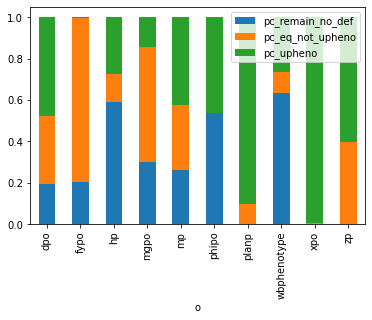

In [26]:
r.set_index('o').plot(kind='bar', stacked=True)